In [56]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe
from wordcloud import WordCloud
from PIL import Image

## Q3.1 Do people care more about lyrics?

#### Description of question
> In this question we will try to find wether people tend to listen to songs that contains certain terms or themes and if popular songs themes differ from the ones discussed in unpopular tracks.

#### High-level idea for solution
> We will use the MusiXmatch dataset combined with the million songs dataset in order to extract popular/unpopular songs lyrics in the bag-of-words format and try different approches to try to extract popular/unpopular topics using term frequencies.

#### Steps
* Fetch approximate equal number of popular and unpopular songs for which we have lyrics
* Remove most uninformative words (stopwords)
* Look at the most frequent top word for each song
* Look at the most frequent words in the whole dataset
* Analysis of the different exctracted topics
* Sentiment analysis of the lyrics (positive/negative songs)
            
Remember all the results and dataset are using a stemmed version of the words!

In [ ]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")
df_mxm_lyrics = read_raw_dataset("mxm_lyrics")
df_mxm_words = read_raw_dataset("mxm_words")

We first choose to take only a subset of the songs with the highest/lowest song_hotttnesss, which is our reference for the popularity of a song. A hotttnesss of at least 0.8 is clearly popular and one of at most 0.4 is unpopular.

In [395]:

#Here we take the worst 10000 songs sorted by hotttnesss (approx 1000 songs with lyrics)
df_bot_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=True).loc[(df_msd_summary['song_hotttnesss'] <= .4) & (df_msd_summary['song_hotttnesss']>0)].head(10000)

#Here we take the top 2000 songs sorted by hotttnesss (approx 1000 songs with lyrics)
df_top_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=False).loc[df_msd_summary['song_hotttnesss'] <= 1].head(2000)
df_top_songs = df_top_songs.set_index('track_id')
df_top_songs.head()

,song_hotttnesss,title,artist_name,duration
track_id,,,,
TRYTLWJ128F1482624,1.0,The Killing Moon,Echo And The Bunnymen,347.34975
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424
TRBFNSL128F42776F9,1.0,Immigrant Song (Album Version),Led Zeppelin,145.05751
TRQJUSS128E07861A6,1.0,Little Sister,Queens Of The Stone Age,211.56526


Here is an example of what the musiXmatch dataset is looking like :

In [372]:
df_mxm_lyrics.sort_values('count',ascending=False).head()

,track_id,mxm_tid,word,count,is_test
2175786,TRDIEOU128F4261A22,775220,woman,718,0
2175778,TRDIEOU128F4261A22,775220,da,450,0
2175773,TRDIEOU128F4261A22,775220,face,319,0
2175771,TRDIEOU128F4261A22,775220,wanna,313,0
16666911,TRZSQUD12903CD0378,5574431,ah,294,0


From this dataset we decide to remove stopwords which we consider to be uninformative (such as I, the, a...) and then get the most repeated word in every single track.

In [373]:
#We remove all lines containing stopwords
stop_wrds = open("./datasets/AdditionalFiles/stop_words.txt","r")
lines = stop_wrds.read().split('\n')
df_mxm_lyrics = df_mxm_lyrics[~df_mxm_lyrics.word.isin(lines)]
df_lyrics = df_mxm_lyrics
df_lyrics = df_lyrics.groupby('track_id')['count','word'].max()
df_lyrics.head()

,count,word
track_id,,
TRAAAAV128F421A322,2,worth
TRAAABD128F429CF47,7,yeah
TRAAAED128E0783FAB,11,whi
TRAAAEF128F4273421,17,world
TRAAAEW128F42930C0,11,wo


In [374]:
#We merge the two dataframes
df_top_songs_word = pd.merge(df_top_songs, df_lyrics, left_index=True, right_index=True, how='inner')
#get rid wrong durations some song is .7 seconds with 7 words occurences which is I think not physically possible
df_top_songs_word = df_top_songs_word[df_top_songs_word['duration'] > 1]
df_top_songs_word.head()

,song_hotttnesss,title,artist_name,duration,count,word
track_id,,,,,,
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302,9,worth
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424,22,world
TRENTGL128E0780C8E,1.0,Clocks,Coldplay,307.51302,9,want
TRIRQPO128F4281996,1.0,We Are The Sleepyheads,Belle & Sebastian,213.73342,3,whenev
TRQFXKD128E0780CAE,1.0,The Scientist,Coldplay,311.27465,17,tell


In [375]:
#We get the dataframe of the stemmed/non-stemmed pair of the words
reverse_map = pd.read_csv("./datasets/mxm_reverse_mapping.txt", sep = "<SEP>")
reverse_map = reverse_map.set_index('word')

/Users/Skan/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


### Songs topics

Here our first approach is to take the most recurrent word in every top/bad song and look at what are the most common top words. From this we will have an idea of how meaningful these words are and whether we can extract some topics from them.

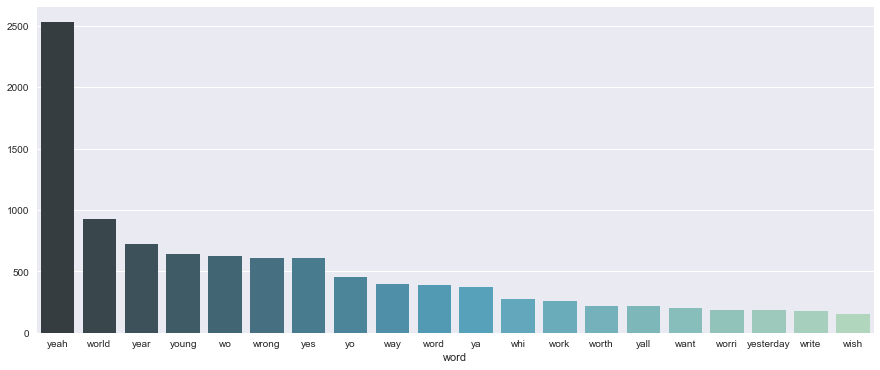

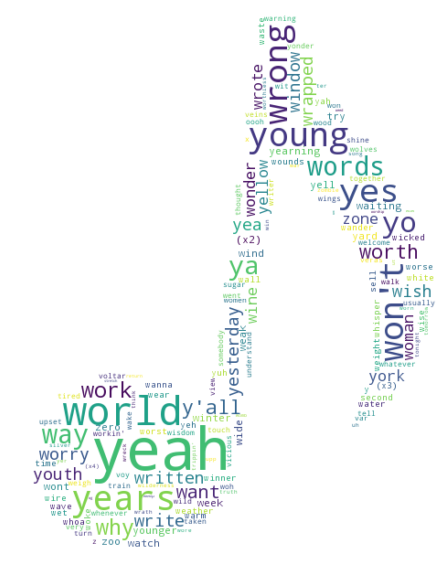

In [388]:
#We plot
a = df_top_songs_word.groupby('word').sum().sort_values('count',ascending=False)[["count"]].head(20)
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']),palette = 'GnBu_d')
plt.show()
plt.close()


a = df_top_songs_word.groupby('word').sum().sort_values('count',ascending=False)[["count"]].head(300)
a['reverse'] = reverse_map[(reverse_map.index.isin(list(a.index)))]
#dict of mapped stemmed words
words = {}
for x in a.index:
    if(a.reverse[x] == a.reverse[x]):
        words[a.reverse[x]] = a['count'][x]

#Converts an image to a mask that is used for the shape of the wordcloud
def convert_mask(mask):
    for x in range(0,len(mask)):
        for y in range(0,len(mask[x])):
            if mask[x][y][3] == 0 : 
                mask[x][y][3] = 0
                mask[x][y][0] = 255
                mask[x][y][1] = 255
                mask[x][y][2] = 255
    return mask

mask = np.array(Image.open("./black_note.png"))
#Create wordcloud
wordcloud = WordCloud(background_color="white", mask=mask).generate_from_frequencies(words)

# Display the generated image:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

To represent the data we use barplots but also word clouds that are a very intuitive representation of the value of each word by its size compared to others. There the top word is by far 'Yeah' and this result is very similar for the worst songs. Hence as a first conclusion we might say people do not really care about lyrics as 'yeah' isn't related to any specific topic.

Next we add weight to top words in function of occurences per duration of song to get a more precise result

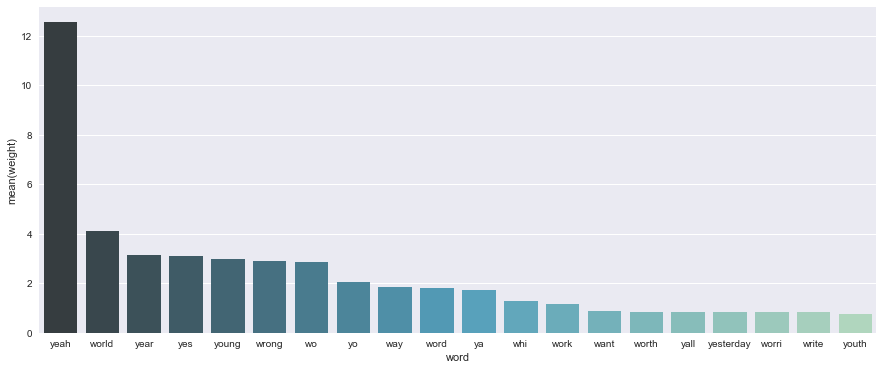

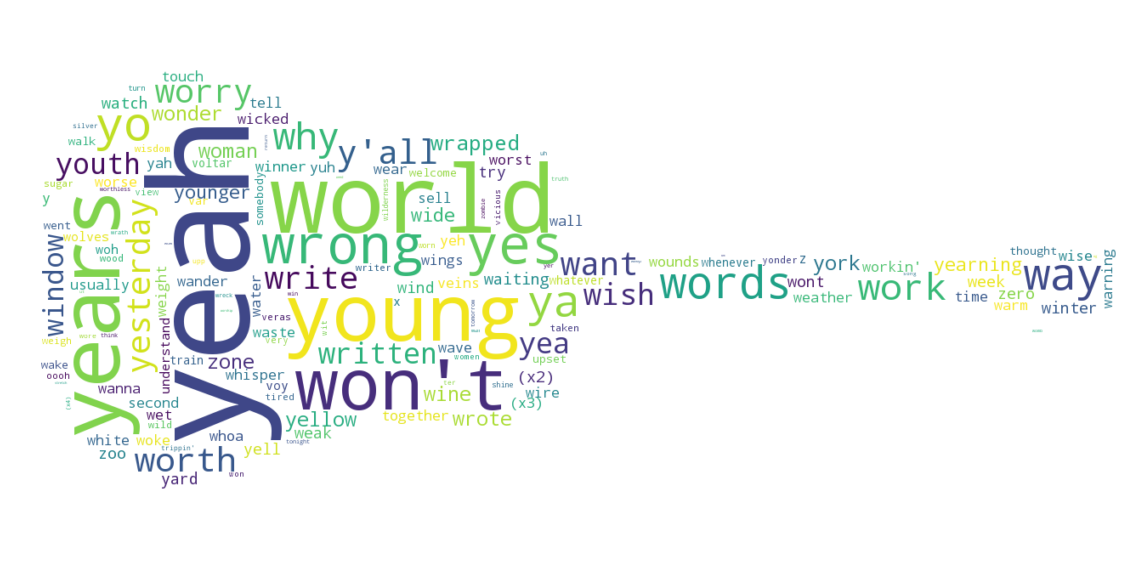

In [390]:
#weighted version
df_top_songs_word["weight"] = df_top_songs_word["count"]/df_top_songs_word["duration"]
a = df_top_songs_word.groupby('word').sum().sort_values('weight',ascending=False)[["count","weight"]].head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,a.weight,palette = 'GnBu_d')
plt.show()
plt.close()

a = df_top_songs_word.groupby('word').sum().sort_values('weight',ascending=False)[["count","weight"]].head(300)
a['reverse'] = reverse_map[(reverse_map.index.isin(list(a.index)))]

words = {}
for x in a.index:
    if(a.reverse[x] == a.reverse[x]):
        words[a.reverse[x]] = a['count'][x]
    
mask = convert_mask(np.array(Image.open("./classic.png")))
    
wordcloud = WordCloud(background_color="white", mask=mask).generate_from_frequencies(words)

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Appart from 'yeah' we can see a lot of top words concerning themes such as youth, the world/people, and verbs that refer to desire(wish, want... (woman ?)) these are similar for the worst songs as well.

Now we consider the full lyrics dataset without taking care of hotttnesss and using counting all the words for every tracks, summing them up to see what is the most recurrent theme.

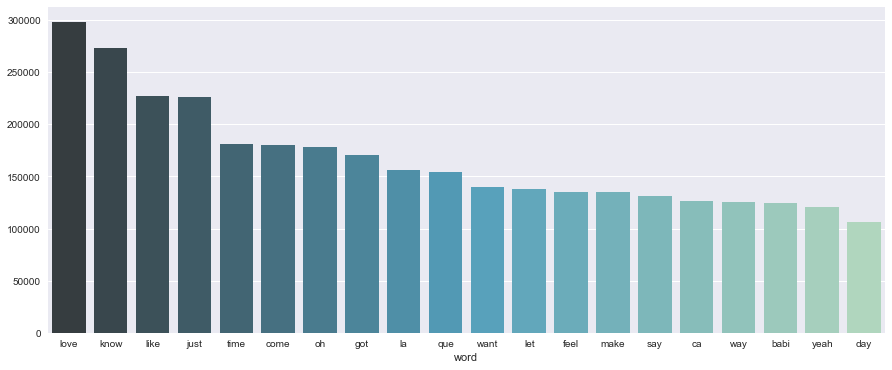

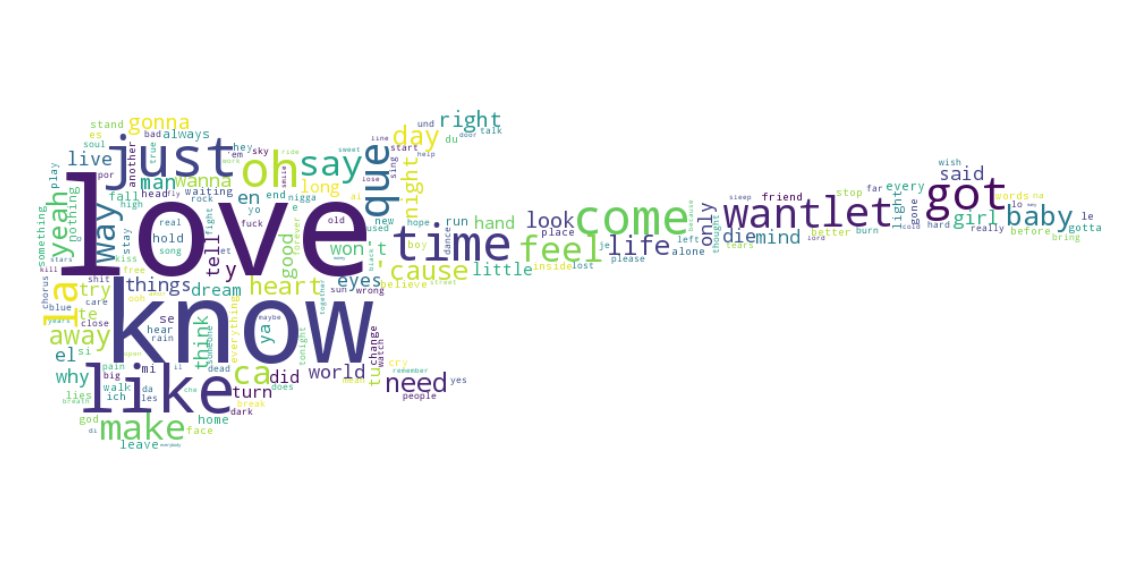

In [391]:
df_mxm_all_wrds = df_mxm_lyrics.groupby('word')['count','word'].sum()
a = df_mxm_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']),palette = 'GnBu_d')
plt.show()
plt.close()

a = df_mxm_all_wrds.sort_values('count',ascending=False).head(300)
a['reverse'] = reverse_map[(reverse_map.index.isin(list(a.index)))]

words = {}
for x in a.index:
    if(a.reverse[x] == a.reverse[x]):
        words[a.reverse[x]] = a['count'][x]
    
mask = convert_mask(np.array(Image.open("./guitar.png")))
wordcloud = WordCloud(background_color="white", mask=mask).generate_from_frequencies(words)

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Here we have a different and interesting result over all the songs we can see that the most recurent word is 'love' and there are many other high-ranked words that recall feelings (feel, like, want, baby, heart, girl...). Next we will repeat the operation, but this time on the top/worst songs we defined earlier.

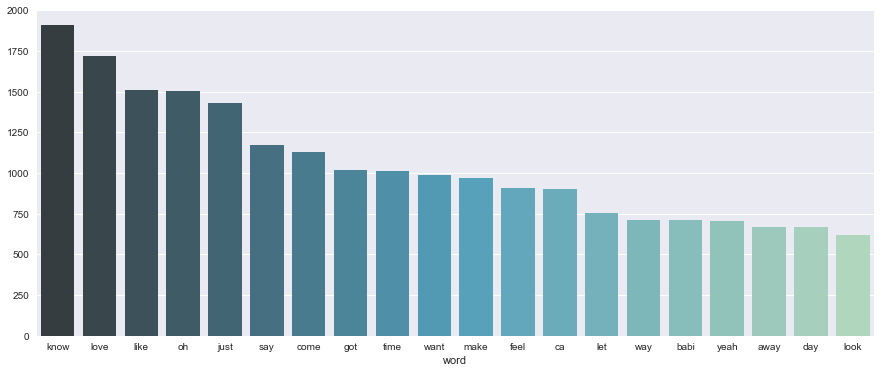

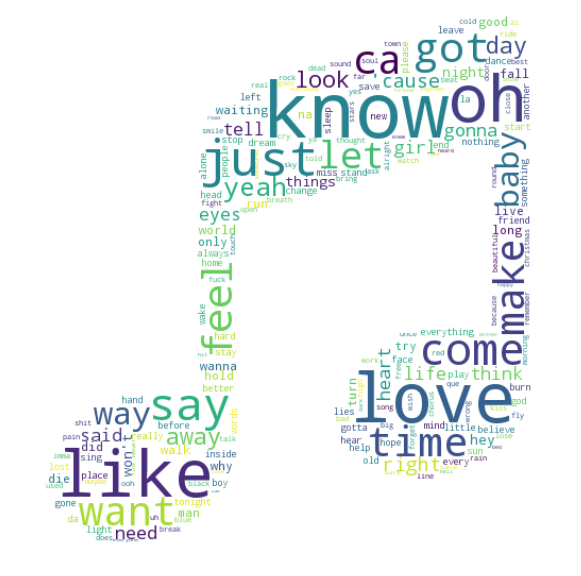

In [392]:
df_top_songs_all_wrds = pd.merge(df_top_songs, df_mxm_lyrics, left_index=True, right_on='track_id', how='inner')
df_top_songs_all_wrds = df_top_songs_all_wrds.groupby('word')['count','word'].sum()
a = df_top_songs_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']),palette = 'GnBu_d')
plt.show()
plt.close()

a = df_top_songs_all_wrds.sort_values('count',ascending=False).head(300)
a['reverse'] = reverse_map[(reverse_map.index.isin(list(a.index)))]

words = {}
for x in a.index:
    if(a.reverse[x] == a.reverse[x]):
        words[a.reverse[x]] = a['count'][x]
    
mask = convert_mask(np.array(Image.open("./croche.png")))
wordcloud = WordCloud(background_color="white",mask=mask).generate_from_frequencies(words)

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We have quiet similar results for top/worst songs, concerning the lyrics we can say that top/worst songs are very similar in terms of themes addressed. There is hence no significant difference between the good and bad songs on the topics they speak of.

### Sentiment Analysis

In this part we use two lists of words that consist of positively/negatively connoted words that were used in "Mining and Summarizing Customer Reviews" by Minqing Hu and Bing Liu. From the lists we will try to determine whether a popular song is usually positive(happy) or negative(sad) using the lyrics of the song from the MusiXmatch dataset.

In [380]:
#read the txt files to make the lists
positive_wrds = open('./datasets/AdditionalFiles/positive-words.txt', 'r')
negative_wrds = open('./datasets/AdditionalFiles/negative-words.txt', 'r', errors='ignore')
positive = [x.strip() for x in positive_wrds.readlines()]
negative = [x.strip() for x in negative_wrds.readlines()]

In [413]:
#Getting the lyrics words in non-stemmed version
df_top_lyrics = pd.merge(df_top_songs, df_mxm_lyrics, left_index=True, right_on="track_id", how='inner')
df_top_lyrics = df_top_lyrics[['song_hotttnesss','title','artist_name','track_id','word','count']].set_index('word')
df_top_lyrics['reverse'] = reverse_map[(reverse_map.index.isin(list(df_top_lyrics.index)))]
df_top_lyrics = df_top_lyrics.set_index('track_id')

#Repeat for worst songs
df_bot_lyrics = pd.merge(df_bot_songs, df_mxm_lyrics, left_on="track_id", right_on="track_id", how='inner')
df_bot_lyrics = df_bot_lyrics[['song_hotttnesss','title','artist_name','track_id','word','count']].set_index('word')
df_bot_lyrics['reverse'] = reverse_map[(reverse_map.index.isin(list(df_bot_lyrics.index)))]
df_bot_lyrics = df_bot_lyrics.set_index('track_id')

In [414]:
#Counting the positive/negative words propotions
df_pos = df_top_lyrics[df_top_lyrics.reverse.isin(positive)].sort_values("count",ascending = False)
df_neg = df_top_lyrics[df_top_lyrics.reverse.isin(negative)].sort_values("count",ascending = False)
df_pos['count_pos'] = df_pos['count']
df_neg['count_neg'] = df_neg['count']
df_sentiment = df_neg.append(df_pos[['artist_name','title','count_pos','reverse']])[['artist_name','title','count_pos','reverse','count_neg']]
df_sentiment = df_sentiment.groupby(df_sentiment.index).sum().fillna(0)
npos = len(df_sentiment[(df_sentiment['count_pos']>df_sentiment['count_neg'])])
nneg = len(df_sentiment[(df_sentiment['count_neg']>df_sentiment['count_pos'])])
print('Top songs : There are '+repr(npos/(npos+nneg))+' positive songs and '+repr(nneg/(npos+nneg))+' negative songs.')

#Repeat for worst songs
df_pos = df_bot_lyrics[df_bot_lyrics.reverse.isin(positive)].sort_values("count",ascending = False)
df_neg = df_bot_lyrics[df_bot_lyrics.reverse.isin(negative)].sort_values("count",ascending = False)
df_pos['count_pos'] = df_pos['count']
df_neg['count_neg'] = df_neg['count']
df_sentiment = df_neg.append(df_pos[['artist_name','title','count_pos','reverse']])[['artist_name','title','count_pos','reverse','count_neg']]
df_sentiment = df_sentiment.groupby(df_sentiment.index).sum().fillna(0)
npos = len(df_sentiment[(df_sentiment['count_pos']>df_sentiment['count_neg'])])
nneg = len(df_sentiment[(df_sentiment['count_neg']>df_sentiment['count_pos'])])
print('Worst songs : There are '+repr(npos/(npos+nneg))+' positive songs and '+repr(nneg/(npos+nneg))+' negative songs.')

Top songs : There are 0.4356060606060606 positive songs and 0.5643939393939394 negative songs.
Worst songs : There are 0.4007682458386684 positive songs and 0.5992317541613317 negative songs.


We can see that we have about 43.6% positive songs and 56.4% negative songs for the tracks with high hotttnesss and about 40% positive songs and 60% negative songs for the tracks with low hotttnesss. There again we have no significant difference between popular and unpopular songs. It might be interesting to redo the same analysis per music genre for further precision.

## Q3.2 Quality and Density of Lyrics in Popular Songs

#### Description of question
> Here we will try to uncover some features that might be characteristic of popular songs, more specifically the density and quality of lyrics in these songs.

#### High-level idea for solution
>  As a starting point we will focus on "slang" words such as insults or controversed subjects and gather their frequencies in popular/unpopular songs which will give us an estimation of the lyrics quality. Then we'll look at how the density of lyrics in a song influences its popularity.


#### Steps
* Fetch slang words 
* Get the proportion of slang words in popular/unpopular songs
* Analyse and compare results
* Compute density of lyrics by counting number of words per song duration

In [383]:
import csv
with open('./datasets/AdditionalFiles/bad_words.csv', 'r') as f:
    reader = csv.reader(f)
    bad_words = list(reader)
bad_words = [row[1][:len(row[1])-1] for row in bad_words][4:]

In [384]:
#We retain the songs containing slang words.
df_mxm_bad = df_mxm_lyrics[df_mxm_lyrics.word.isin(bad_words)].sort_values("count",ascending = False)

In [385]:
df_bad_count = df_mxm_bad.groupby('track_id')['count','word'].sum()
df_top_bad_songs = pd.merge(df_top_songs, df_bad_count, left_index=True, right_index=True, how='inner')
print("We have a ratio of "+repr(len(df_top_bad_songs)/len(df_top_songs_word))+" top songs with bad words")
df_ratio = pd.merge(df_mxm_lyrics.groupby('track_id')['count','word'].sum(), df_top_bad_songs, left_index=True, right_index=True, how='inner')
df_ratio['ratio'] = df_ratio['count_y']/df_ratio['count_x']
df_ratio.sort_values('ratio',ascending=False)[['song_hotttnesss','title','ratio']].head()

We have a ratio of 0.3063533507397737 top songs with bad words


,song_hotttnesss,title,ratio
track_id,,,
TRQUHKZ128F930304E,0.884117,My Generation,0.214815
TROXWIE128F92D1249,0.895749,Dusk Till Dawn,0.210526
TRESXNP128EF350B90,0.899010,Fuck The Pain Away,0.198718
TRSKYDX12903CFA1D1,0.964620,Born to Party,0.194444
TRKMBDM128E0783E27,0.880696,Hollaback Girl,0.188119


We have a ratio of 0.3063533507397737 top songs with bad words. For the low hotttnesss songs we can actually see that we only have 0.22113502935420742 as a ratio. We can also see that some songs with a very high hotttness having 1/5 words being a slang word, so people might be more interested in borderline songs ?

### Lyrics density

Here we will try to see wether the sparsity of the lyrics in a songs influences its popularity (i.e. if a high density of words implies popularity).

In [386]:
df_density = df_mxm_lyrics.groupby("track_id").sum()
df_density = pd.merge(df_top_songs, df_density, left_index=True, right_index=True, how='inner')
df_density['density'] = df_density['count'] /df_density['duration']
df_density = df_density.sort_values('density',ascending = True)
df_density.head()

,song_hotttnesss,title,artist_name,duration,mxm_tid,count,is_test,density
track_id,,,,,,,,
TRNCXNX128F4282732,0.927425,Festival,Sigur Rós,565.13261,21852384,3,0,0.005308
TRLQUGG128F4261B0E,0.915077,Olsen Olsen,Sigur Ros,483.13424,4405912,6,0,0.012419
TRNKWUD128F92FEB41,0.900961,Music Is Math,Boards of Canada,321.46240,3361132,4,0,0.012443
TRWUKDU128F92E4963,0.879231,Om Nashi Me,Edward Sharpe & The Magnetic Zeros,376.05832,26090667,5,0,0.013296
TRFAOTA128E07989E0,0.940713,Heysátan,Sigur Rós,249.62567,11900784,6,0,0.024036


In [387]:
#We do this because theres a lot of wrong word count/duration
df_density= df_density.loc[df_density['density'] < 1.9]
print("On average we have "+repr(df_density['density'].mean())+" words per second for the top songs")

On average we have 0.4521405468229473 words per second for the top songs


We have 0.42832003048718376 for the worst and 0.45214054682294735 for the top the difference is quiet small and I do not think we can come to a conclusion due to the fact there might be many errors in the word counts.

As a conclusion 
> We can say that most songs have recurrent themes, **usually love and people** but these do not really influence the popularity of the song. 

> It was also found that these songs are usually **negative (sad) songs** more than *positive (happy) songs*. 

> We saw a slight trend for songs that contain **slang/obscene words**, they might be more popular than *"polite"* due to the fact they might shock the public ?

> Also a song's popularity does not usually rely on the density or quality of their lyrics, as we saw in question 3.1 the most common word for the majority of the songs is **'yeah'** and the **lyrics sparsity isn't relevant either**.